In [6]:
# Data manipulations imports
import pandas as pd
import numpy as np
import os

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Geo Data Manipulation imports
import geopandas as gpd
from shapely.geometry import Point, box
from geopy.distance import geodesic

# Machine Learning imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut


# Get data from the CSVs and store in one dataframe


In [8]:
# Specify the path to the folder containing the CSV files
folder_path = "C:/Users/msanh/OneDrive/Documents/Certifications/Data-Analytics-Program/Data-Analytics-Projects/Case-Study-1-Bike-Share/Datasets"

# List all CSV files within the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Create an empty list to store the DataFrames
data_frames = []

# Iterate through each CSV file and read it into a DataFrame
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    data_frames.append(df)
    
# Concatenate all DataFrames into a single DataFrame
all_trips_df = pd.concat(data_frames, ignore_index=True)

# Display the first few rows of the combined DataFrame
all_trips_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,F96D5A74A3E41399,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,TA1309000058,Hampden Ct & Diversey Ave,202480.0,41.924074,-87.646278,41.930000,-87.640000,member
1,13CB7EB698CEDB88,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member
2,BD88A2E670661CE5,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,RP-005,Valli Produce - Evanston Plaza,599,42.008571,-87.690483,42.039742,-87.699413,casual
3,C90792D034FED968,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member
4,3397017529188E8A,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member


# Check the dataframe


In [3]:
all_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5719877 entries, 0 to 5719876
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 567.3+ MB


## Convert `started_at` and `ended_at` columns to datetime format


In [4]:
all_trips_df['started_at'] = pd.to_datetime(all_trips_df['started_at'])
all_trips_df['ended_at'] = pd.to_datetime(all_trips_df['ended_at'])
all_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5719877 entries, 0 to 5719876
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 567.3+ MB


## Switch the `started_at` and `ended_at` values for the invalid rides


In [5]:
# Check rows where start time is after end time

invalid_rides = all_trips_df[all_trips_df['started_at'] > all_trips_df['ended_at']].copy()
# View results
print(f'Number of invalid start and end time: {invalid_rides.shape[0]}')

Number of invalid start and end time: 272


In [6]:
invalid_rides['started_at'] = pd.to_datetime(invalid_rides['started_at'])
invalid_rides['ended_at'] = pd.to_datetime(invalid_rides['ended_at'])

# Switch the 'started_at' and 'ended_at' values for these rides
invalid_rides[['started_at', 'ended_at']] = invalid_rides[['ended_at', 'started_at']]

# Assign corrected values back to original DataFrame
all_trips_df.loc[invalid_rides.index, ['started_at', 'ended_at']] = invalid_rides[['started_at', 'ended_at']]

# Verify the fix
print(f'Number of invalid start and end time: {all_trips_df[all_trips_df['started_at'] > all_trips_df['ended_at']].shape[0]}') 

Number of invalid start and end time: 0


# Check for missing values

In [7]:
print(f'Total number of records: {all_trips_df.shape[0]}')
print('Number of missing data:')
print(all_trips_df.isnull().sum())

Total number of records: 5719877
Number of missing data:
ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    875716
start_station_id      875848
end_station_name      929202
end_station_id        929343
start_lat                  0
start_lng                  0
end_lat                 6990
end_lng                 6990
member_casual              0
dtype: int64


## Filter out the rows where all end station columns have null values


In [8]:
# Check the missing end station information

missing_end_station = all_trips_df[all_trips_df[['end_station_name', 'end_station_id', 'end_lat', 'end_lng']].isnull().all(axis=1)]
print(f'Number of end station with no data: {missing_end_station.shape[0]}')

Number of end station with no data: 6874


In [9]:
cleaned_trips_df = all_trips_df[~all_trips_df[['end_station_name', 'end_station_id', 'end_lat', 'end_lng']].isnull().all(axis=1)]
print(f'Total number of records: {cleaned_trips_df.shape[0]}')
print('Number of missing data:')
print(cleaned_trips_df.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    875716
start_station_id      875848
end_station_name      922328
end_station_id        922469
start_lat                  0
start_lng                  0
end_lat                  116
end_lng                  116
member_casual              0
dtype: int64


## Write a function to Create batches for better performance

In [10]:
def create_batches(df, batch_size):
    """
    Create batches from the original DataFrame.

    Parameters:
    - df: Original DataFrame
    - batch_size: Size of each batch

    Returns:
    - List of DataFrames, each representing a batch
    """
    num_batches = len(df) // batch_size + 1
    return [df.iloc[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

## Fill the missing `end_lng` and `end_lat` in `cleaned_trips_df`

In [11]:
# Identify stations with missing end coordinates
missing_end_coords_stations = cleaned_trips_df[cleaned_trips_df[['end_lat', 'end_lng']].isnull().all(axis=1)]['end_station_name']

# Iterate through stations in batches and fill missing end coordinates
for station_batch in create_batches(pd.Series(list(missing_end_coords_stations)), batch_size=100000):
    for station in station_batch:
        matching_records = cleaned_trips_df[(cleaned_trips_df['start_station_name'] == station) | (cleaned_trips_df['end_station_name'] == station)]

        first_non_null_lat = matching_records[['start_lat', 'end_lat']].stack().dropna().iloc[0]
        first_non_null_lng = matching_records[['start_lng', 'end_lng']].stack().dropna().iloc[0]

        # Update station coords with the first non-null lat and lng values
        cleaned_trips_df.loc[cleaned_trips_df['end_station_name'] == station, 'end_lat'] = first_non_null_lat
        cleaned_trips_df.loc[cleaned_trips_df['end_station_name'] == station, 'end_lng'] = first_non_null_lng

# Check the update
print(f'Total number of records: {cleaned_trips_df.shape[0]}')
print('Number of missing data:')
print(cleaned_trips_df.isnull().sum())


Total number of records: 5713003
Number of missing data:
ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    875716
start_station_id      875848
end_station_name      922328
end_station_id        922469
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
dtype: int64


## Create the `start_stations_df`

In [12]:
start_stations_df = pd.DataFrame(cleaned_trips_df[['ride_id','rideable_type','started_at','ended_at','start_station_id','start_station_name', 'start_lat', 'start_lng', 'member_casual']])

start_stations_df.rename(columns={
    'start_station_id': 'station_id',
    'start_station_name': 'station_name',
    'start_lat': 'station_lat',
    'start_lng': 'station_lng'
}, inplace=True)

start_stations_df['start'] = True

# Check the dataframe
print(f'Total number of records: {start_stations_df.shape[0]}')
print('Number of missing data:')
print(start_stations_df.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id               0
rideable_type         0
started_at            0
ended_at              0
station_id       875848
station_name     875716
station_lat           0
station_lng           0
member_casual         0
start                 0
dtype: int64


## Create the `end_stations_df`

In [13]:
end_stations_df = pd.DataFrame(cleaned_trips_df[['ride_id','rideable_type','started_at','ended_at','end_station_id','end_station_name', 'end_lat', 'end_lng', 'member_casual']])

end_stations_df.rename(columns={
    'end_station_id': 'station_id',
    'end_station_name': 'station_name',
    'end_lat': 'station_lat',
    'end_lng': 'station_lng'
}, inplace=True)

end_stations_df['start'] = False

# Check the dataframe
print(f'Total number of records: {end_stations_df.shape[0]}')
print('Number of missing data:')
print(end_stations_df.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id               0
rideable_type         0
started_at            0
ended_at              0
station_id       922469
station_name     922328
station_lat           0
station_lng           0
member_casual         0
start                 0
dtype: int64


## Create the `combined_stations_df`

In [14]:
combined_stations_df = pd.concat([start_stations_df, end_stations_df], ignore_index=True)

# Check the dataframe
print(f'Total number of records: {combined_stations_df.shape[0]}')
print('Number of missing data:')
print(combined_stations_df.isnull().sum())

Total number of records: 11426006
Number of missing data:
ride_id                0
rideable_type          0
started_at             0
ended_at               0
station_id       1798317
station_name     1798044
station_lat            0
station_lng            0
member_casual          0
start                  0
dtype: int64


## Create the `station_info_df` 

In [15]:
# Filter records with unique station_name
unique_stations_df = combined_stations_df[~combined_stations_df.duplicated(['station_name'])].dropna()

# Check the number of unique stations
num_unique_stations = len(unique_stations_df)
print(f"Number of unique stations: {num_unique_stations}")

Number of unique stations: 1615


In [16]:
# Filter records with unique station_ids
unique_stations_df = unique_stations_df[~unique_stations_df.duplicated(['station_id'])].dropna()

# Check the dataframe
print(f'Total number of records: {unique_stations_df.shape[0]}')
print('Number of missing data:')
print(unique_stations_df.isnull().sum())

Total number of records: 1524
Number of missing data:
ride_id          0
rideable_type    0
started_at       0
ended_at         0
station_id       0
station_name     0
station_lat      0
station_lng      0
member_casual    0
start            0
dtype: int64


In [17]:
# Filter records with unique longitude and latitude
unique_stations_df = unique_stations_df[~unique_stations_df.duplicated(subset=['station_lat','station_lng'])].dropna()

# Check the dataframe
print(f'Total number of records: {unique_stations_df.shape[0]}')
print('Number of missing data:')
print(unique_stations_df.isnull().sum())

Total number of records: 1254
Number of missing data:
ride_id          0
rideable_type    0
started_at       0
ended_at         0
station_id       0
station_name     0
station_lat      0
station_lng      0
member_casual    0
start            0
dtype: int64


In [18]:
station_info_df = unique_stations_df[['station_name', 'station_id', 'station_lat', 'station_lng']]

# Check the dataframe
print(f'Total number of stations: {station_info_df.shape[0]}')
print('Number of missing data:')
print(station_info_df.isnull().sum())

Total number of stations: 1254
Number of missing data:
station_name    0
station_id      0
station_lat     0
station_lng     0
dtype: int64


## Create the `station_info_gdf` geodataframe

In [19]:
station_info_gdf = gpd.GeoDataFrame(station_info_df[['station_id','station_name', 'station_lat', 'station_lng']],
                                    geometry=gpd.points_from_xy(station_info_df['station_lng'],station_info_df['station_lat']),  # Set the geometry column to 'geometry'
                                    crs='EPSG:4326')  # Set CRS immediately

# Check the update
print(f'Total number of stations: {station_info_gdf.shape[0]}')
print('Number of missing data:')
print(station_info_gdf.isnull().sum())

Total number of stations: 1254
Number of missing data:
station_id      0
station_name    0
station_lat     0
station_lng     0
geometry        0
dtype: int64


# Create an interactive map of stations

In [20]:
fig = px.scatter_mapbox(
    station_info_gdf,
    lat=station_info_gdf.geometry.y,
    lon=station_info_gdf.geometry.x,
    hover_name='station_name',
    hover_data={'station_id': True},
    color='station_name',
    center=dict(lat=station_info_gdf['station_lat'].mean(), lon=station_info_gdf['station_lng'].mean()),  # Set center to the mean of coordinates  
    zoom=10,
    mapbox_style="open-street-map",
    opacity=0.8,
    size_max=15
)

fig.update_layout(
    title='Station Locations',
    margin={"r": 0, "t": 30, "l": 0, "b": 0},
    showlegend=False,
    mapbox_style="open-street-map"
)

fig.show()


c:\Users\msanh\anaconda3\envs\data-analysis-env\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


# Fill the missing station names in `combined_stations_df` using KNN model

In [21]:
# Prepare data for KNN
X_train = station_info_df[['station_lat', 'station_lng']]
y_train = station_info_df['station_name']
X_test = combined_stations_df[['station_lat', 'station_lng']].dropna()

# Cross-validation with class-aware splitting
k_values = range(1, 11)
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    skf = LeaveOneOut()  # Adjust splits for classes
    scores = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
    accuracies.append(scores.mean())

best_k = k_values[accuracies.index(max(accuracies))]

# Train KNN model with best K
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Predict missing station names
predicted_names = knn.predict(X_test)
combined_stations_df.loc[X_test.index, 'station_name'] = predicted_names

# Check the output
print(f'K value: {best_k}')
print(f'Total number of records: {combined_stations_df.shape[0]}')
print('Number of missing data:')
print(combined_stations_df.isnull().sum())


K value: 1
Total number of records: 11426006
Number of missing data:
ride_id                0
rideable_type          0
started_at             0
ended_at               0
station_id       1798317
station_name           0
station_lat            0
station_lng            0
member_casual          0
start                  0
dtype: int64


## Create the `combined_stations_gdf` geodataframe

In [22]:
combined_stations_gdf = gpd.GeoDataFrame(combined_stations_df[['ride_id','rideable_type','started_at','ended_at','station_id','station_name', 'station_lat', 'station_lng', 'member_casual', 'start']],
                                    geometry=gpd.points_from_xy(combined_stations_df['station_lng'],combined_stations_df['station_lat']),  # Set the geometry column to 'geometry'
                                    crs='EPSG:4326')  # Set CRS immediately

# Check the dataframe
print(f'Total number of records: {combined_stations_gdf.shape[0]}')
print('Number of missing data:')
print(combined_stations_gdf.isnull().sum())


Total number of records: 11426006
Number of missing data:
ride_id                0
rideable_type          0
started_at             0
ended_at               0
station_id       1798317
station_name           0
station_lat            0
station_lng            0
member_casual          0
start                  0
geometry               0
dtype: int64


# Create the `stations_bbox` bounding boxes

In [23]:
stations_bbox = gpd.GeoDataFrame(geometry=combined_stations_gdf.groupby('station_name')['geometry']
                                  .apply(lambda group: box(group.x.min(), group.y.min(), group.x.max(), group.y.max())))

stations_bbox.rename(columns={'geometry': 'bounding_box'}, inplace=True)

# Check the output
print(f'Total number of records: {stations_bbox.shape[0]}')
print('Number of missing data:')
print(stations_bbox.isnull().sum())

Total number of records: 1254
Number of missing data:
bounding_box    0
dtype: int64


In [24]:
stations_bbox.head()

,bounding_box
station_name,
2112 W Peterson Ave,"POLYGON ((-87.68000 41.99000, -87.68000 41.991..."
63rd St Beach,"POLYGON ((-87.57559 41.78000, -87.57559 41.785..."
900 W Harrison St,"POLYGON ((-87.64718 41.87356, -87.64718 41.875..."
Aberdeen St & Jackson Blvd,"POLYGON ((-87.65381 41.87560, -87.65381 41.878..."
Aberdeen St & Monroe St,"POLYGON ((-87.65438 41.88009, -87.65438 41.881..."


## Merge `stations_bbox` with `station_info_gdf` based on `station_name`

In [25]:
station_info_gdf = pd.merge(station_info_gdf, stations_bbox, left_on='station_name', right_index=True, how='left')

# Check the output
print(f'Total number of records: {station_info_gdf.shape[0]}')
print('Number of missing data:')
print(station_info_gdf.isnull().sum())

Total number of records: 1254
Number of missing data:
station_id      0
station_name    0
station_lat     0
station_lng     0
geometry        0
bounding_box    0
dtype: int64


# Create the `centroid` column in `station_info_gdf`

In [26]:
station_info_gdf['centroid'] = station_info_gdf['bounding_box'].apply(lambda x: x.centroid if x else None)

# Check the output
print(f'Total number of records: {station_info_gdf.shape[0]}')
print('Number of missing data:')
print(station_info_gdf.isnull().sum())

Total number of records: 1254
Number of missing data:
station_id      0
station_name    0
station_lat     0
station_lng     0
geometry        0
bounding_box    0
centroid        0
dtype: int64


## Create an interactive map for the station's bounding boxes 

In [27]:
# Create map for bounding boxes
fig = px.choropleth_mapbox(
    stations_bbox,
    locations=stations_bbox.index,
    geojson=stations_bbox.bounding_box,  # Use 'bounding_box' for geometry
    hover_name=stations_bbox.index,
    opacity=0.5,
    zoom=10,
    center=dict(lat=station_info_gdf['station_lat'].mean(), lon=station_info_gdf['station_lng'].mean()),
    mapbox_style="carto-positron"
)

# Add trip markers (corrected)
fig.add_scattermapbox(
    lat=station_info_gdf.centroid.y,  # Access y-coordinate of centroids
    lon=station_info_gdf.centroid.x,  # Access x-coordinate of centroids
    mode='markers',
    marker=dict(size=5, color='red')
)

fig.update_layout(title='Stations with Bounding Boxes', margin={"r": 0, "t": 30, "l": 0, "b": 0})
fig.show()

C:\Users\msanh\AppData\Local\Temp\ipykernel_44976\1084211258.py:15: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\msanh\AppData\Local\Temp\ipykernel_44976\1084211258.py:16: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




# Update `combined_stations_df` based on the `station_info_df`

In [28]:
# Update columns in combined_stations_df with information from station_info_df
combined_stations_df = combined_stations_df.merge(station_info_df[['station_id', 'station_name', 'station_lat', 'station_lng']],
                                                  on=['station_name'], suffixes=('_old', ''))

# Check the output
print(f'Total number of records: {combined_stations_df.shape[0]}')
print('Number of missing data:')
print(combined_stations_df.isnull().sum())

Total number of records: 11426006
Number of missing data:
ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
station_id_old     1798317
station_name             0
station_lat_old          0
station_lng_old          0
member_casual            0
start                    0
station_id               0
station_lat              0
station_lng              0
dtype: int64


In [29]:
# drop old columns 
columns_to_drop = [col for col in combined_stations_df.columns if col.endswith('_old')]
if columns_to_drop:
    combined_stations_df.drop(columns=columns_to_drop, inplace=True)


# Check the output
print(f'Total number of records: {combined_stations_df.shape[0]}')
print('Number of missing data:')
print(combined_stations_df.isnull().sum())

Total number of records: 11426006
Number of missing data:
ride_id          0
rideable_type    0
started_at       0
ended_at         0
station_name     0
member_casual    0
start            0
station_id       0
station_lat      0
station_lng      0
dtype: int64


## Update the `combined_stations_gdf`  geo locations data based on the `stations_info_gdf`

In [30]:
import geopandas as gpd
from shapely.geometry import Point, box

# Update columns in combined_stations_gdf with information from station_info_gdf
combined_stations_gdf = combined_stations_gdf.merge(station_info_gdf,
                                                  on=['station_name'], suffixes=('_old', ''))


# Check the output
print(f'Total number of records: {combined_stations_gdf.shape[0]}')
print('Number of missing data:')
print(combined_stations_gdf.isnull().sum())

Total number of records: 11426006
Number of missing data:
ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
station_id_old     1798317
station_name             0
station_lat_old          0
station_lng_old          0
member_casual            0
start                    0
geometry_old             0
station_id               0
station_lat              0
station_lng              0
geometry                 0
bounding_box             0
centroid                 0
dtype: int64


In [31]:
# drop old columns 
columns_to_drop = [col for col in combined_stations_gdf.columns if col.endswith('_old')]
if columns_to_drop:
    combined_stations_gdf.drop(columns=columns_to_drop, inplace=True)


# Check the output
print(f'Total number of records: {combined_stations_gdf.shape[0]}')
print('Number of missing data:')
print(combined_stations_gdf.isnull().sum())

Total number of records: 11426006
Number of missing data:
ride_id          0
rideable_type    0
started_at       0
ended_at         0
station_name     0
member_casual    0
start            0
station_id       0
station_lat      0
station_lng      0
geometry         0
bounding_box     0
centroid         0
dtype: int64


# Recreate the `start_stations_df` and `end_station_df` 

In [32]:
# Initialize empty DataFrames to accumulate results
start_stations_df = pd.DataFrame()
end_stations_df = pd.DataFrame()

# Process DataFrames in batches
for batch_df in create_batches(combined_stations_df, 100000):
    # Split start and end stations within the batch
    start_df = batch_df[batch_df['start']]
    end_df = batch_df[~batch_df['start']]

    # Concat to the respective DataFrames directly
    start_stations_df = pd.concat([start_stations_df, start_df], ignore_index=True)
    end_stations_df = pd.concat([end_stations_df, end_df], ignore_index=True)

# Rename columns after all batches are processed
start_stations_df.rename(columns={
    'station_id': 'start_station_id',
    'station_name': 'start_station_name',
    'station_lat': 'start_lat',
    'station_lng': 'start_lng'
}, inplace=True)

end_stations_df.rename(columns={
    'station_id': 'end_station_id',
    'station_name': 'end_station_name',
    'station_lat': 'end_lat',
    'station_lng': 'end_lng'
}, inplace=True)

# Check the start stations dataframe
print(f'Total number of records: {start_stations_df.shape[0]}')
print('Number of missing data:')
print(start_stations_df.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
member_casual         0
start                 0
start_station_id      0
start_lat             0
start_lng             0
dtype: int64


In [33]:
# Check the start stations dataframe
print(f'Total number of records: {start_stations_df.shape[0]}')
print('Number of missing data:')
print(start_stations_df.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
member_casual         0
start                 0
start_station_id      0
start_lat             0
start_lng             0
dtype: int64


In [34]:
# Check the dataframe
print(f'Total number of records: {end_stations_df.shape[0]}')
print('Number of missing data:')
print(end_stations_df.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id             0
rideable_type       0
started_at          0
ended_at            0
end_station_name    0
member_casual       0
start               0
end_station_id      0
end_lat             0
end_lng             0
dtype: int64


## Merge the `start_stations_df` and `end_stations_df` into `filled_stations_df`

In [35]:
filled_stations_df = pd.merge(
    start_stations_df, end_stations_df, on=['ride_id','rideable_type','started_at','ended_at','member_casual']
)

# drop unnecessary columns 
if "start_x" or "start_y" in filled_stations_df:
    filled_stations_df.drop(["start_x", "start_y"], axis=1, inplace=True)


# Check the dataframe
print(f'Total number of records: {filled_stations_df.shape[0]}')
print('Number of missing data:')
print(filled_stations_df.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
member_casual         0
start_station_id      0
start_lat             0
start_lng             0
end_station_name      0
end_station_id        0
end_lat               0
end_lng               0
dtype: int64


## Create GeoDataframes

## Create the `start_stations_gdf` geodataframe

In [36]:
start_stations = combined_stations_gdf[combined_stations_gdf['start']]

start_stations_gdf = gpd.GeoDataFrame(start_stations,
                                    geometry='geometry',  # Set the geometry column to 'geometry'
                                    crs=start_stations.crs)  # Set CRS immediately

# Rename columns after all batches are processed
start_stations_gdf.rename(columns={
    'station_id': 'start_station_id',
    'station_name': 'start_station_name',
    'station_lat': 'start_lat',
    'station_lng': 'start_lng',
    'geometry': 'geometry_start',
    'bounding_box': 'bounding_box_start',
    'centroid': 'centroid_start'
}, inplace=True)

# Check the dataframe
print(f'Total number of records: {start_stations_gdf.shape[0]}')
print('Number of missing data:')
print(start_stations_gdf.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
member_casual         0
start                 0
start_station_id      0
start_lat             0
start_lng             0
geometry_start        0
bounding_box_start    0
centroid_start        0
dtype: int64


## Create the `end_stations_gdf` geodataframe

In [37]:
end_stations = combined_stations_gdf[~combined_stations_gdf['start']]

end_stations_gdf = gpd.GeoDataFrame(end_stations,
                                    geometry='geometry',  # Set the geometry column to 'geometry'
                                    crs=end_stations.crs)  # Set CRS immediately


end_stations_gdf.rename(columns={
    'station_id': 'end_station_id',
    'station_name': 'end_station_name',
    'station_lat': 'end_lat',
    'station_lng': 'end_lng',
    'geometry': 'geometry_end',
    'bounding_box': 'bounding_box_end',
    'centroid': 'centroid_end'
}, inplace=True)


# Check the dataframe
print(f'Total number of records: {end_stations_gdf.shape[0]}')
print('Number of missing data:')
print(end_stations_gdf.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id             0
rideable_type       0
started_at          0
ended_at            0
end_station_name    0
member_casual       0
start               0
end_station_id      0
end_lat             0
end_lng             0
geometry_end        0
bounding_box_end    0
centroid_end        0
dtype: int64


## Create the `filled_stations_gdf` geodataframe

In [38]:
filled_stations= pd.merge(start_stations_gdf, end_stations_gdf, on=['ride_id', 'rideable_type', 'started_at', 'ended_at', 'member_casual'])


# Convert longitude and latitude to a GeoDataFrame
filled_stations_gdf = gpd.GeoDataFrame(
    filled_stations,
    geometry=gpd.points_from_xy(filled_stations['start_lng'],filled_stations['start_lat']),
    crs='EPSG:4326'
)

# Create geometry_end
filled_stations_gdf['geometry_end'] = gpd.GeoSeries(gpd.points_from_xy(filled_stations['end_lng'], filled_stations['end_lat']),
                              index=filled_stations.index)

# Rename columns 
filled_stations_gdf.rename(columns={
    'geometry': 'geometry_start',
}, inplace=True)

# drop unnecessary columns 
if "start_x" or "start_y" in filled_stations_gdf:
    filled_stations_gdf.drop(["start_x", "start_y"], axis=1, inplace=True)


# Check the GeoDataFrame
print(f"GeoDataFrame created with {filled_stations_gdf.shape[0]} records")
print('Number of missing data:')
print(filled_stations_gdf.isnull().sum())

GeoDataFrame created with 5713003 records
Number of missing data:
ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
member_casual         0
start_station_id      0
start_lat             0
start_lng             0
geometry_start        0
bounding_box_start    0
centroid_start        0
end_station_name      0
end_station_id        0
end_lat               0
end_lng               0
geometry_end          0
bounding_box_end      0
centroid_end          0
geometry_start        0
dtype: int64


# Run Exploratory Data Analysis

## Create a `ride_count` column in `station_info_df` and `station_info_gdf` 

In [39]:
# Calculate ride counts from start_stations_df
station_ride_counts = (start_stations_df.groupby('start_station_name')['ride_id'].count()).reset_index()
station_ride_counts.columns = ['station_name', 'ride_count']

# Merge and fill NaNs
station_info_df = pd.merge(station_info_df, station_ride_counts, on='station_name', how='left')
station_info_df.fillna({'ride_count': 0}, inplace=True)

# Merge and recreate GeoDataFrame, then fill NaNs separately
station_info_gdf = gpd.GeoDataFrame(pd.merge(station_info_gdf, station_ride_counts, on='station_name', how='left'))
station_info_gdf.fillna({'ride_count': 0}, inplace=True)

In [40]:
# Check the DataFrame
print(f"DataFrame created with {station_info_df.shape[0]} records")
print('Number of missing data:')
print(station_info_df.isnull().sum())

DataFrame created with 1254 records
Number of missing data:
station_name    0
station_id      0
station_lat     0
station_lng     0
ride_count      0
dtype: int64


In [41]:
# Check the GeoDataFrame
print(f"GeoDataFrame created with {station_info_gdf.shape[0]} records")
print('Number of missing data:')
print(station_info_gdf.isnull().sum())

GeoDataFrame created with 1254 records
Number of missing data:
station_id      0
station_name    0
station_lat     0
station_lng     0
geometry        0
bounding_box    0
centroid        0
ride_count      0
dtype: int64


## Calculate Number of Rides by Rider Type

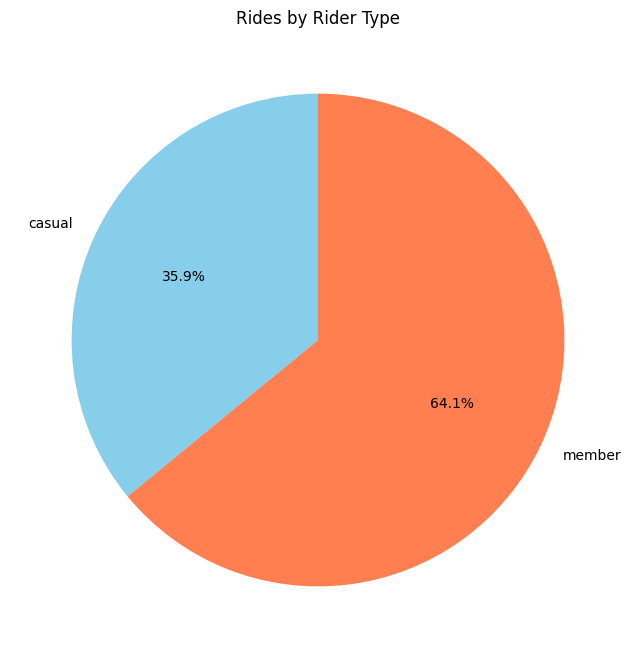

Number of Rides by Rider Type:
  Rider Type  Number of Rides
0     casual          2053423
1     member          3659580


In [42]:
# Group by rider type and count the number of rides
ride_counts_by_type = start_stations_df.groupby('member_casual')['ride_id'].count().reset_index()

# Rename the columns for better readability
ride_counts_by_type.columns = ['Rider Type', 'Number of Rides']

# Plot the results as a pie chart using Seaborn
plt.figure(figsize=(8, 8))
sns.set_palette(['skyblue', 'coral'])
plt.pie(ride_counts_by_type['Number of Rides'], labels=ride_counts_by_type['Rider Type'], autopct='%1.1f%%', startangle=90)
plt.title('Rides by Rider Type')
plt.show()

# Print the results
print(f'Number of Rides by Rider Type:\n{ride_counts_by_type}')

In [43]:
# Create a scatter map using Plotly for the start stations with a red color scale
start_fig = px.scatter_mapbox(
    station_info_gdf,
    lat="station_lat",
    lon="station_lng",
    color="ride_count",
    hover_name='station_name',
    hover_data={'station_id': True},
    color_continuous_scale="reds",
    size_max=20,
    mapbox_style="carto-positron",
    zoom=10,
    center=dict(lat=station_info_gdf['station_lat'].mean(), lon=station_info_gdf['station_lng'].mean())
)

start_fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
start_fig.show()

# Print the results
print(f'The top 10 stations:\n{station_ride_counts.sort_values('ride_count',ascending=False).head(10)}')

The top 10 stations:
                           station_name  ride_count
1140            Streeter Dr & Grand Ave       72875
414            Kingsbury St & Kinzie St       48509
424            LaSalle St & Illinois St       47355
251   DuSable Lake Shore Dr & Monroe St       40927
1156           University Ave & 57th St       39825
167              Clark St & Schiller St       38973
108                 Canal St & Adams St       38672
70              Broadway & Waveland Ave       38529
341         Halsted St & Wrightwood Ave       37541
519               Michigan Ave & Oak St       37314


# Create routes information

## Create `same_station_route_df` for rides with similar start and end stations

In [44]:
# Filter out rides starting and ending at the same station
same_station_route_df = filled_stations_df[filled_stations_df['start_station_name'] == filled_stations_df['end_station_name']]

# Check the dataframe
print(f'Total number of same station rides: {same_station_route_df.shape[0]}')

Total number of same station rides: 408840


## Create `different_station_df` for rides with different start and end stations

In [45]:
# Filter out rides starting and ending at the same station
different_station_df = filled_stations_df[filled_stations_df['start_station_name'] != filled_stations_df['end_station_name']]

# Check the dataframe
print(f'Total number of rides with different stations: {different_station_df.shape[0]}')

Total number of rides with different stations: 5304163


## Create a `route` and `route_distance` column in `different_station_df`

In [46]:
# Create a function to calculate the route distances
def get_distance(location1: dict, location2: dict):
    try:
        distance = geodesic((location1["latitude"], location1["longitude"]),
                            (location2["latitude"], location2["longitude"])).kilometers
        return distance
    except Exception as e:
        return print("Failed to retrieve distance")

In [47]:
# Process each batch in a loop
batches = []
for batch in create_batches(different_station_df, 100000):
    # Explicitly create a copy of the batch to avoid potential modifications within create_batches
    batch = batch.copy()  # Ensure a fresh copy for clarity

    # Modify the copied batch using .loc
    batch.loc[:, 'route'] = batch[['start_station_name', 'end_station_name']].apply(lambda x: ' - '.join(x), axis=1)
    batch.loc[:, 'route_distance'] = batch.apply(
        lambda row: get_distance(
            location1={'latitude': row['start_lat'], 'longitude': row['start_lng']},
            location2={'latitude': row['end_lat'], 'longitude': row['end_lng']}
        ),
        axis=1
    )

    # Append the modified batch to the list
    batches.append(batch)

# Concatenate the processed batches
different_station_df = pd.concat(batches)



# Check the DataFrame (no changes needed here)
print(f'Total number of records: {different_station_df.shape[0]}')
print('Number of missing data:')
print(different_station_df.isnull().sum())


Total number of records: 5304163
Number of missing data:
ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
member_casual         0
start_station_id      0
start_lat             0
start_lng             0
end_station_name      0
end_station_id        0
end_lat               0
end_lng               0
route                 0
route_distance        0
dtype: int64


## Create the `routes_df` with unique routes

In [48]:
# Create a DataFrame with unique routes
routes_df = different_station_df[['route','start_lat', 'end_lat', 'start_lng', 'end_lng', 'route_distance']].drop_duplicates()

# Check the dataframe
print(f'Total number of records: {routes_df.shape[0]}')
print('Number of missing data:')
print(routes_df.isnull().sum())

Total number of records: 207351
Number of missing data:
route             0
start_lat         0
end_lat           0
start_lng         0
end_lng           0
route_distance    0
dtype: int64


## Get the top 10 routes with different start and end station

In [49]:
# Group by route and count the number of rides
ride_counts_by_route = different_station_df.groupby('route')['ride_id'].count()

# Sort the ride counts in descending order
sorted_routes = ride_counts_by_route.sort_values(ascending=False)

# Display the top 10 routes
sorted_routes.head(10)

route
Ellis Ave & 60th St - University Ave & 57th St                 7766
University Ave & 57th St - Ellis Ave & 60th St                 7094
Ellis Ave & 60th St - Ellis Ave & 55th St                      6966
Ellis Ave & 55th St - Ellis Ave & 60th St                      6404
DuSable Lake Shore Dr & Monroe St - Streeter Dr & Grand Ave    5697
Calumet Ave & 33rd St - State St & 33rd St                     5474
State St & 33rd St - Calumet Ave & 33rd St                     5374
Loomis St & Lexington St - Morgan St & Polk St                 4133
University Ave & 57th St - Kimbark Ave & 53rd St               3929
Morgan St & Polk St - Loomis St & Lexington St                 3751
Name: ride_id, dtype: int64

## Get the top 10 same station rides

In [50]:
# Group by route and count the number of rides
same_station_ride_counts = same_station_route_df.groupby('start_station_name')['ride_id'].count()

# Sort the ride counts in descending order
sorted_same_station_rides = same_station_ride_counts.sort_values(ascending=False)

# Display the top 10 routes
sorted_same_station_rides.head(10)

start_station_name
Streeter Dr & Grand Ave              13243
DuSable Lake Shore Dr & Monroe St     7692
University Ave & 57th St              6009
Montrose Harbor                       5253
Michigan Ave & Oak St                 5249
LaSalle St & Illinois St              5013
Indiana Ave & Roosevelt Rd            4918
New St & Illinois St                  4124
Millennium Park                       3858
Theater on the Lake                   3850
Name: ride_id, dtype: int64

## Calculate the total `route_distance`  in kilometers by rider type

c:\Users\msanh\anaconda3\envs\data-analysis-env\Lib\site-packages\seaborn\_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\msanh\anaconda3\envs\data-analysis-env\Lib\site-packages\seaborn\_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



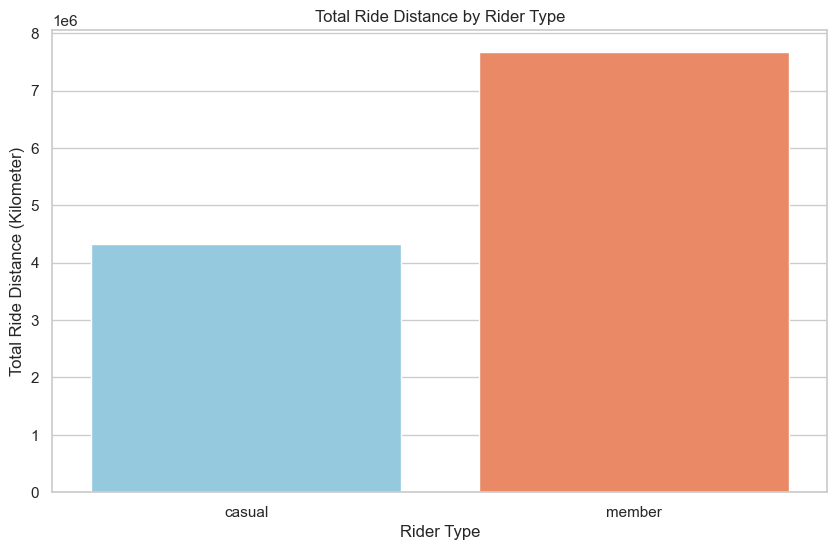

Total ride distance for members: 7667602.43 kilometers
Total ride distance for casual riders: 4326707.74 kilometers
Difference of ride distance: 3340894.69 kilometers


In [51]:
# Group by rider type and calculate the total route distance
total_ride_distance_by_type = different_station_df.groupby('member_casual')['route_distance'].sum().reset_index()

# Rename the columns for better readability
total_ride_distance_by_type.columns = ['Rider Type', 'Total Ride Distance (Kilometer)']

# create variables for easier access
total_ride_distance_members = total_ride_distance_by_type.loc[total_ride_distance_by_type['Rider Type']=='member', 'Total Ride Distance (Kilometer)'].values[0]
total_ride_distance_casual = total_ride_distance_by_type.loc[total_ride_distance_by_type['Rider Type']=='casual', 'Total Ride Distance (Kilometer)'].values[0]
difference_ride_distance = total_ride_distance_members - total_ride_distance_casual

# Set the style for better readability
sns.set(style="whitegrid")

# Plot the results as a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Rider Type', y='Total Ride Distance (Kilometer)', data=total_ride_distance_by_type, palette={'casual': 'skyblue', 'member': 'coral'}, hue='Rider Type')

# Customize the axes labels and layout
plt.xlabel('Rider Type')
plt.ylabel('Total Ride Distance (Kilometer)')
plt.title('Total Ride Distance by Rider Type')

# Show the plot
plt.show()

# Print the results
print(f"Total ride distance for members: {total_ride_distance_members:.2f} kilometers")
print(f"Total ride distance for casual riders: {total_ride_distance_casual:.2f} kilometers")
print(f"Difference of ride distance: {difference_ride_distance:.2f} kilometers")

## Calculate the `avg_ride_distance_by_type` and plot it

c:\Users\msanh\anaconda3\envs\data-analysis-env\Lib\site-packages\seaborn\_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\msanh\anaconda3\envs\data-analysis-env\Lib\site-packages\seaborn\_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



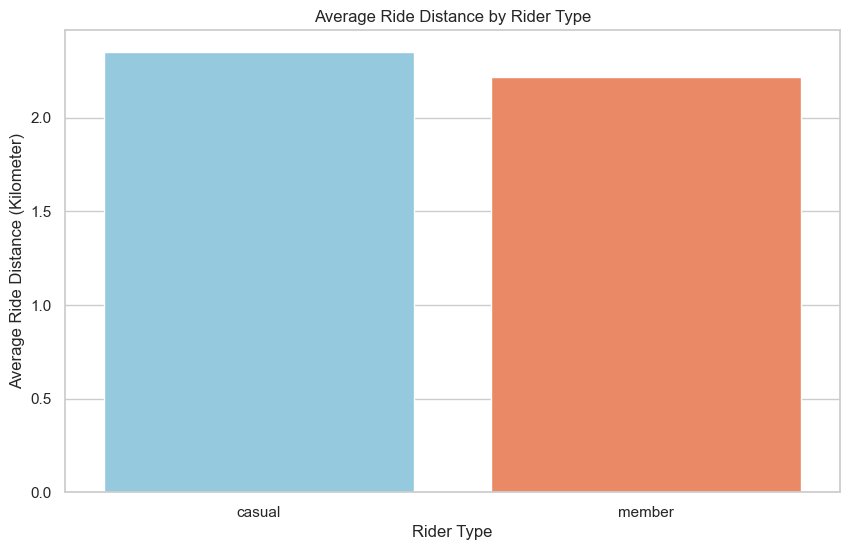

Average ride distance for members: 2.21 kilometers
Average ride distance for casual riders: 2.35 kilometers
Difference of average ride distance: -0.13 kilometers


In [52]:
# Group by rider type and calculate the average route distance
avg_ride_distance_by_type = different_station_df.groupby('member_casual')['route_distance'].mean().reset_index()

# Rename the columns for better readability
avg_ride_distance_by_type.columns = ['Rider Type', 'Average Ride Distance (Kilometer)']

# create variables for easier access
avg_ride_distance_members = avg_ride_distance_by_type.loc[avg_ride_distance_by_type['Rider Type']=='member', 'Average Ride Distance (Kilometer)'].values[0]
avg_ride_distance_casual = avg_ride_distance_by_type.loc[avg_ride_distance_by_type['Rider Type']=='casual', 'Average Ride Distance (Kilometer)'].values[0]
avg_difference_ride_distance = avg_ride_distance_members - avg_ride_distance_casual

# Set the style for better readability
sns.set(style="whitegrid")

# Plot the results as a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Rider Type', y='Average Ride Distance (Kilometer)', data=avg_ride_distance_by_type, palette={'casual': 'skyblue', 'member': 'coral'}, hue='Rider Type')

# Customize the axes labels and layout
plt.xlabel('Rider Type')
plt.ylabel('Average Ride Distance (Kilometer)')
plt.title('Average Ride Distance by Rider Type')

# Show the plot
plt.show()

# Print the results
print(f"Average ride distance for members: {avg_ride_distance_members:.2f} kilometers")
print(f"Average ride distance for casual riders: {avg_ride_distance_casual:.2f} kilometers")
print(f"Difference of average ride distance: {avg_difference_ride_distance:.2f} kilometers")

## Create a `ride_length` column in minutes

In [53]:
# Calculate ride length in minutes
filled_stations_df['ride_length'] = (filled_stations_df['ended_at'] - filled_stations_df['started_at']).dt.total_seconds() /60

# View the new column
print(f'Total number of records: {filled_stations_df.shape[0]}')
filled_stations_df[['started_at','ended_at','ride_length']].head()

Total number of records: 5713003


,started_at,ended_at,ride_length
0,2023-01-21 20:05:42,2023-01-21 20:16:33,10.850000
1,2023-01-10 15:37:36,2023-01-10 15:46:05,8.483333
2,2023-01-02 07:51:57,2023-01-02 08:05:11,13.233333
3,2023-01-22 10:52:58,2023-01-22 11:01:44,8.766667
4,2023-01-12 13:58:01,2023-01-12 14:13:20,15.316667


## Calculate the average `ride_length` in minutes by rider type

c:\Users\msanh\anaconda3\envs\data-analysis-env\Lib\site-packages\seaborn\_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\msanh\anaconda3\envs\data-analysis-env\Lib\site-packages\seaborn\_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



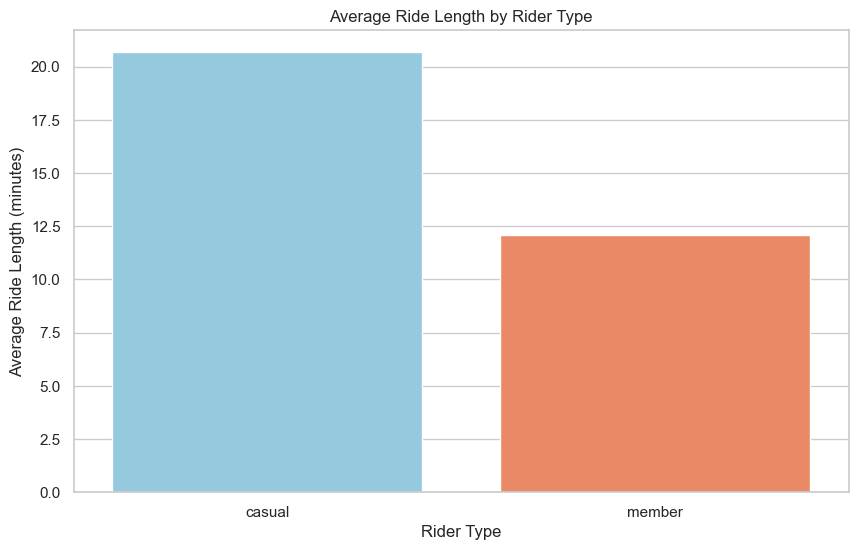

Average ride length for members: 12.09 minutes
Average ride length for casual riders: 20.68 minutes


In [54]:
# Group by rider type and calculate the average ride length
avg_ride_length_by_type = filled_stations_df.groupby('member_casual')['ride_length'].mean().reset_index()
avg_ride_length_by_type.columns = ['Rider Type', 'Average Ride Length (minutes)']

# Set the style for better readability
sns.set(style="whitegrid")

# Plot the results as a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Rider Type', y='Average Ride Length (minutes)', data=avg_ride_length_by_type, palette={'casual': 'skyblue', 'member': 'coral'}, hue='Rider Type')

# Customize the axes labels and layout
plt.xlabel('Rider Type')
plt.ylabel('Average Ride Length (minutes)')
plt.title('Average Ride Length by Rider Type')

# Show the plot
plt.show()

# Print the results
print(f"Average ride length for members: {avg_ride_length_by_type.loc[avg_ride_length_by_type['Rider Type']=='member', 'Average Ride Length (minutes)'].values[0]:.2f} minutes")
print(f"Average ride length for casual riders: {avg_ride_length_by_type.loc[avg_ride_length_by_type['Rider Type']=='casual', 'Average Ride Length (minutes)'].values[0]:.2f} minutes")

## Plot the `rideable_type` by rider type

<Figure size 1200x600 with 0 Axes>

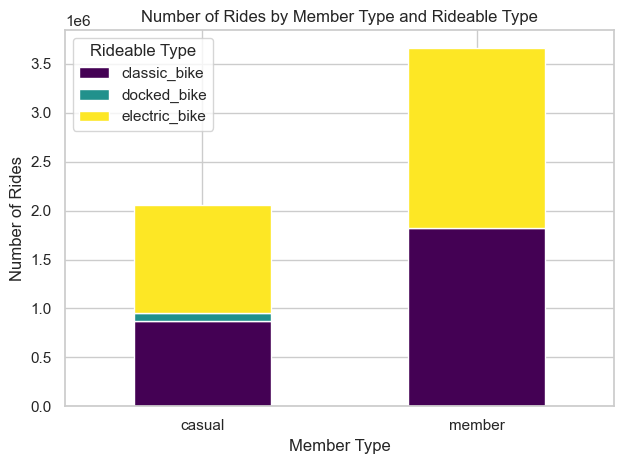

Number of Rides by Member Type and Rideable Type:
rideable_type  classic_bike  docked_bike  electric_bike
member_casual                                          
casual             873172.0      76240.0      1104011.0
member            1818012.0          NaN      1841568.0


In [55]:
# Group by rideable_type and member_casual, count rides
rideable_type_member = filled_stations_df.groupby(['member_casual', 'rideable_type'])['ride_id'].count().unstack()

# Plot the results with Seaborn for clear hue distinction
sns.set_style("whitegrid")  # Set style for better readability
plt.figure(figsize=(12, 6))

# Stacked bar chart
rideable_type_member.plot(kind='bar', stacked=True, colormap='viridis')

# Customize the plot
plt.xlabel('Member Type')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Member Type and Rideable Type')
plt.legend(title='Rideable Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the results
print(f'Number of Rides by Member Type and Rideable Type:\n{rideable_type_member}')

## Use One-hot encoding for the `rideable_type`

In [56]:
# One-hot encode the rideable_type column
rideable_type_encoded = pd.get_dummies(filled_stations_df["rideable_type"], prefix="rideable_type_")

# Add the encoded columns to the DataFrame
filled_stations_df = pd.concat([filled_stations_df, rideable_type_encoded], axis=1)

# Check the dataframe
print(f'Total number of records: {filled_stations_df.shape[0]}')
print('Number of missing data:')
print(filled_stations_df.isnull().sum())

Total number of records: 5713003
Number of missing data:
ride_id                         0
rideable_type                   0
started_at                      0
ended_at                        0
start_station_name              0
member_casual                   0
start_station_id                0
start_lat                       0
start_lng                       0
end_station_name                0
end_station_id                  0
end_lat                         0
end_lng                         0
ride_length                     0
rideable_type__classic_bike     0
rideable_type__docked_bike      0
rideable_type__electric_bike    0
dtype: int64


# Create a `classic_bike_df` dataframe

In [57]:
classic_bike_df = filled_stations_df[filled_stations_df['rideable_type__classic_bike']]

# Check the dataframe
print(f'Total number of records: {classic_bike_df.shape[0]}')
print('Number of missing data:')
print(classic_bike_df.isnull().sum())

Total number of records: 2691184
Number of missing data:
ride_id                         0
rideable_type                   0
started_at                      0
ended_at                        0
start_station_name              0
member_casual                   0
start_station_id                0
start_lat                       0
start_lng                       0
end_station_name                0
end_station_id                  0
end_lat                         0
end_lng                         0
ride_length                     0
rideable_type__classic_bike     0
rideable_type__docked_bike      0
rideable_type__electric_bike    0
dtype: int64


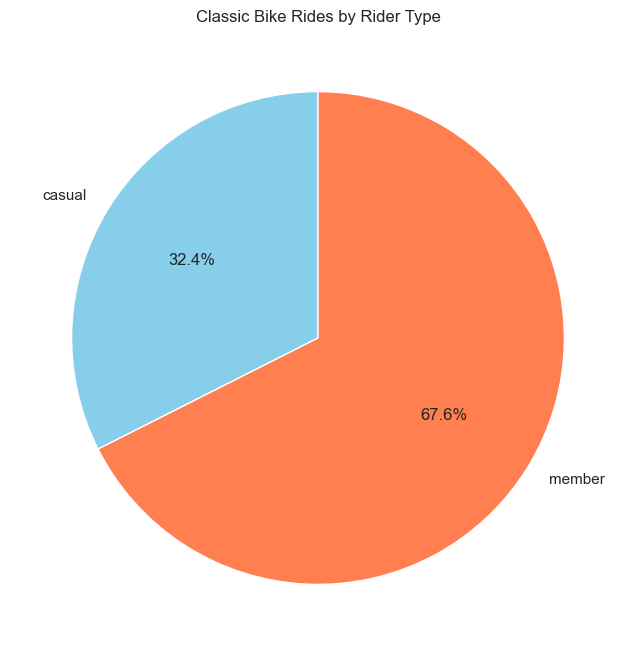

Number of Classic Bike Rides by Rider Type:
  Rider Type  Number of Classic Bike Rides
0     casual                        873172
1     member                       1818012


In [58]:
# Group by rider type and count the number of rides
classic_ride_count_by_type = classic_bike_df.groupby('member_casual')['ride_id'].count().reset_index()

# Rename the columns for better readability
classic_ride_count_by_type.columns = ['Rider Type', 'Number of Classic Bike Rides']

# Plot the results as a pie chart using Seaborn
plt.figure(figsize=(8, 8))
sns.set_palette(['skyblue', 'coral'])
plt.pie(classic_ride_count_by_type['Number of Classic Bike Rides'], labels=classic_ride_count_by_type['Rider Type'], autopct='%1.1f%%', startangle=90)
plt.title('Classic Bike Rides by Rider Type')
plt.show()

# Print the results
print(f'Number of Classic Bike Rides by Rider Type:\n{classic_ride_count_by_type}')

## Update the `station_info_df` and `station_info_gdf` with the `classic_bike_ride_count`

In [59]:
# Calculate ride counts for classic bikes
classic_bike_ride_count = (classic_bike_df.groupby('start_station_name')['ride_id'].count()).reset_index()
classic_bike_ride_count.columns = ['station_name', 'classic_bike_ride_count']

# Merge and fill NaNs
station_info_df = pd.merge(station_info_df, classic_bike_ride_count, on='station_name', how='left')
station_info_df.fillna({'classic_bike_ride_count': 0}, inplace=True)

# Merge and recreate GeoDataFrame, then fill NaNs separately
station_info_gdf = gpd.GeoDataFrame(pd.merge(station_info_gdf, classic_bike_ride_count, on='station_name', how='left'))
station_info_gdf.fillna({'classic_bike_ride_count': 0}, inplace=True)


In [60]:
# Create a scatter map using Plotly for the classic bike with a red color scale
start_fig = px.scatter_mapbox(
    station_info_gdf,
    lat="station_lat",
    lon="station_lng",
    hover_name='station_name',
    hover_data={'station_id': True},
    color="classic_bike_ride_count",
    color_continuous_scale="reds",
    size_max=20,
    mapbox_style="carto-positron",
    zoom=10,
    center=dict(lat=station_info_gdf['station_lat'].mean(), lon=station_info_gdf['station_lng'].mean())
)

start_fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
start_fig.show()

# Print the results
print(f'The top 10 classic bike ride stations:\n{classic_bike_ride_count.sort_values('classic_bike_ride_count',ascending=False).head(10)}')

The top 10 classic bike ride stations:
                           station_name  classic_bike_ride_count
639             Streeter Dr & Grand Ave                    41400
235   DuSable Lake Shore Dr & Monroe St                    26177
461               Michigan Ave & Oak St                    23332
236  DuSable Lake Shore Dr & North Blvd                    23304
142                   Clark St & Elm St                    22122
643                 Theater on the Lake                    21057
332          Indiana Ave & Roosevelt Rd                    20611
373            Kingsbury St & Kinzie St                    20156
255                 Ellis Ave & 60th St                    19805
651            University Ave & 57th St                    19637


# Create a `docked_bike_df` dataframe

In [61]:
docked_bike_df = filled_stations_df[filled_stations_df['rideable_type__docked_bike']]

# Check the dataframe
print(f'Total number of records: {docked_bike_df.shape[0]}')
print('Number of missing data:')
print(docked_bike_df.isnull().sum())

Total number of records: 76240
Number of missing data:
ride_id                         0
rideable_type                   0
started_at                      0
ended_at                        0
start_station_name              0
member_casual                   0
start_station_id                0
start_lat                       0
start_lng                       0
end_station_name                0
end_station_id                  0
end_lat                         0
end_lng                         0
ride_length                     0
rideable_type__classic_bike     0
rideable_type__docked_bike      0
rideable_type__electric_bike    0
dtype: int64


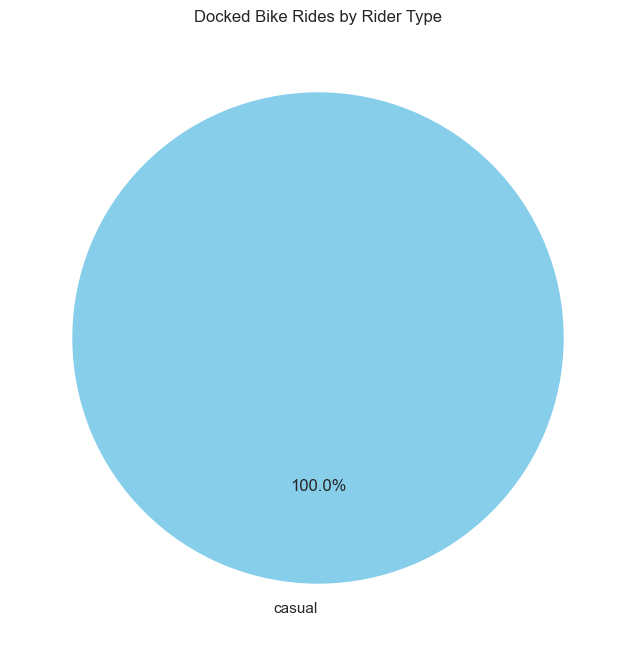

Number of Docked Bike Rides by Rider Type:
  Rider Type  Number of Docked Bike Rides
0     casual                        76240


In [62]:
# Group by rider type and count the number of rides
docked_ride_count_by_type = docked_bike_df.groupby('member_casual')['ride_id'].count().reset_index()

# Rename the columns for better readability
docked_ride_count_by_type.columns = ['Rider Type', 'Number of Docked Bike Rides']

# Plot the results as a pie chart using Seaborn
plt.figure(figsize=(8, 8))
sns.set_palette(['skyblue', 'coral'])
plt.pie(docked_ride_count_by_type['Number of Docked Bike Rides'], labels=docked_ride_count_by_type['Rider Type'], autopct='%1.1f%%', startangle=90)
plt.title('Docked Bike Rides by Rider Type')
plt.show()

# Print the results
print(f'Number of Docked Bike Rides by Rider Type:\n{docked_ride_count_by_type}')

## Update the `station_info_df` and `station_info_gdf` with the `docked_bike_ride_count`

In [63]:
# Calculate ride counts for docked bikes
docked_bike_ride_count = (docked_bike_df.groupby('start_station_name')['ride_id'].count()).reset_index()
docked_bike_ride_count.columns = ['station_name', 'docked_bike_ride_count']

# Merge and fill NaNs
station_info_df = pd.merge(station_info_df, docked_bike_ride_count, on='station_name', how='left')
station_info_df.fillna({'docked_bike_ride_count': 0}, inplace=True)

# Merge and recreate GeoDataFrame, then fill NaNs separately
station_info_gdf = gpd.GeoDataFrame(pd.merge(station_info_gdf, docked_bike_ride_count, on='station_name', how='left'))
station_info_gdf.fillna({'docked_bike_ride_count': 0}, inplace=True)

In [64]:
# Create a scatter map using Plotly for the docked bike with a red color scale
start_fig = px.scatter_mapbox(
    station_info_gdf,
    lat="station_lat",
    lon="station_lng",
    hover_name='station_name',
    hover_data={'station_id': True},
    color="docked_bike_ride_count",
    color_continuous_scale="reds",
    size_max=20,
    mapbox_style="carto-positron",
    zoom=10,
    center=dict(lat=station_info_gdf['station_lat'].mean(), lon=station_info_gdf['station_lng'].mean())
)

start_fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
start_fig.show()

# Print the results
print(f'The top 10 docked bike ride stations:\n{docked_bike_ride_count.sort_values('docked_bike_ride_count',ascending=False).head(10)}')

The top 10 docked bike ride stations:
                           station_name  docked_bike_ride_count
559             Streeter Dr & Grand Ave                    4505
214   DuSable Lake Shore Dr & Monroe St                    3409
411                     Millennium Park                    2289
494                      Shedd Aquarium                    2024
405               Michigan Ave & Oak St                    1711
218                      Dusable Harbor                    1685
215  DuSable Lake Shore Dr & North Blvd                    1475
7                     Adler Planetarium                    1350
417                     Montrose Harbor                    1086
562                 Theater on the Lake                    1029


# Create a `electric_bike_df` dataframe

In [65]:
electric_bike_df = filled_stations_df[filled_stations_df['rideable_type__electric_bike']]

# Check the dataframe
print(f'Total number of records: {electric_bike_df.shape[0]}')
print('Number of missing data:')
print(electric_bike_df.isnull().sum())

Total number of records: 2945579
Number of missing data:
ride_id                         0
rideable_type                   0
started_at                      0
ended_at                        0
start_station_name              0
member_casual                   0
start_station_id                0
start_lat                       0
start_lng                       0
end_station_name                0
end_station_id                  0
end_lat                         0
end_lng                         0
ride_length                     0
rideable_type__classic_bike     0
rideable_type__docked_bike      0
rideable_type__electric_bike    0
dtype: int64


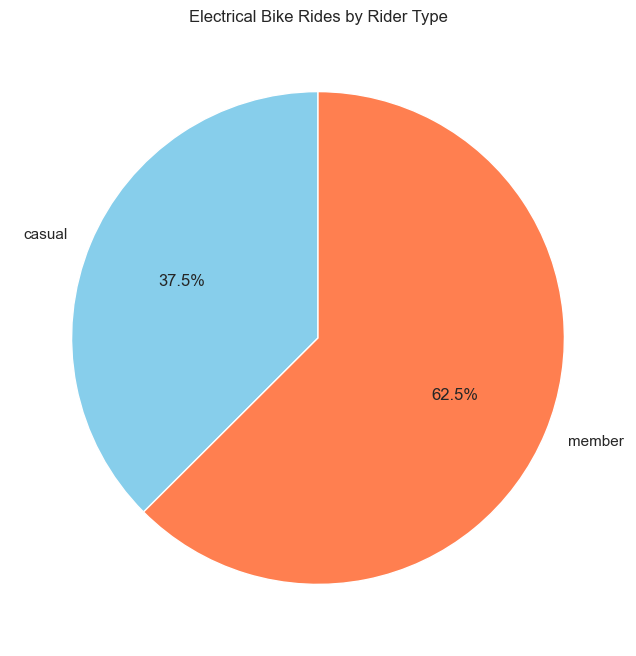

Number of Electrical Bike Rides by Rider Type:
  Rider Type  Number of Electrical Bike Rides
0     casual                          1104011
1     member                          1841568


In [66]:
# Group by rider type and count the number of rides
electric_ride_count_by_type = electric_bike_df.groupby('member_casual')['ride_id'].count().reset_index()

# Rename the columns for better readability
electric_ride_count_by_type.columns = ['Rider Type', 'Number of Electrical Bike Rides']

# Plot the results as a pie chart using Seaborn
plt.figure(figsize=(8, 8))
sns.set_palette(['skyblue', 'coral'])
plt.pie(electric_ride_count_by_type['Number of Electrical Bike Rides'], labels=electric_ride_count_by_type['Rider Type'], autopct='%1.1f%%', startangle=90)
plt.title('Electrical Bike Rides by Rider Type')
plt.show()

# Print the results
print(f'Number of Electrical Bike Rides by Rider Type:\n{electric_ride_count_by_type}')

## Update the `station_info_df` and `station_info_gdf` with the `electrical_bike_ride_count`

In [67]:
# Calculate ride counts for docked bikes
electrical_bike_ride_count = (electric_bike_df.groupby('start_station_name')['ride_id'].count()).reset_index()
electrical_bike_ride_count.columns = ['station_name', 'electrical_bike_ride_count']

# Merge and fill NaNs
station_info_df = pd.merge(station_info_df, electrical_bike_ride_count, on='station_name', how='left')
station_info_df.fillna({'electrical_bike_ride_count': 0}, inplace=True)

# Merge and recreate GeoDataFrame, then fill NaNs separately
station_info_gdf = gpd.GeoDataFrame(pd.merge(station_info_gdf, electrical_bike_ride_count, on='station_name', how='left'))
station_info_gdf.fillna({'electrical_bike_ride_count': 0}, inplace=True)

In [68]:
# Create a scatter map using Plotly for the electrical bike with a red color scale
start_fig = px.scatter_mapbox(
    station_info_gdf,
    lat="station_lat",
    lon="station_lng",
    hover_name='station_name',
    hover_data={'station_id': True},
    color="electrical_bike_ride_count",
    color_continuous_scale="reds",
    size_max=20,
    mapbox_style="carto-positron",
    zoom=10,
    center=dict(lat=station_info_gdf['station_lat'].mean(), lon=station_info_gdf['station_lng'].mean())
)

start_fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
start_fig.show()


# Print the results
print(f'The top 10 electrical bike ride stations:\n{electrical_bike_ride_count.sort_values('electrical_bike_ride_count',ascending=False).head(10)}')

The top 10 electrical bike ride stations:
                     station_name  electrical_bike_ride_count
423      LaSalle St & Illinois St                       34164
413      Kingsbury St & Kinzie St                       28188
167        Clark St & Schiller St                       27627
1137      Streeter Dr & Grand Ave                       26970
108           Canal St & Adams St                       26829
341   Halsted St & Wrightwood Ave                       26002
156           Clark St & Grace St                       25661
70        Broadway & Waveland Ave                       25601
554          New St & Illinois St                       23689
232        Dearborn St & Adams St                       22968


## Create `hour_of_day`, `day_of_week` and `month` variables in `filled_stations_df`

In [69]:
# Extract hour of the day 
filled_stations_df['hour_of_day'] = filled_stations_df['started_at'].dt.hour

# Extract the weekday. Formatted as a number, with 1 = Sunday and 7 = Saturday.
filled_stations_df['day_of_week'] = filled_stations_df['started_at'].dt.weekday + 1

# Extract the month
filled_stations_df['month'] = filled_stations_df['started_at'].dt.month

In [70]:
filled_stations_df[['started_at','hour_of_day']].head()
filled_stations_df[['started_at','day_of_week']].head()
filled_stations_df[['started_at','month']].head()

,started_at,month
0,2023-01-21 20:05:42,1
1,2023-01-10 15:37:36,1
2,2023-01-02 07:51:57,1
3,2023-01-22 10:52:58,1
4,2023-01-12 13:58:01,1


## Calculate the mode of `hour_of_day`, `day_of_week` and `month`

In [71]:
mode_hour_of_day = filled_stations_df['hour_of_day'].mode().iloc[0]
mode_day_of_week = filled_stations_df['day_of_week'].mode().iloc[0]
mode_month = filled_stations_df['month'].mode().iloc[0]

# Print the modes
print(f"Day Hour Mode: {mode_hour_of_day}")
print(f"Week Day Mode: {mode_day_of_week}")
print(f"Month Mode: {mode_month}")

Day Hour Mode: 17
Week Day Mode: 6
Month Mode: 8


## Calculate the `ride_counts_by_hour_member` and plot it

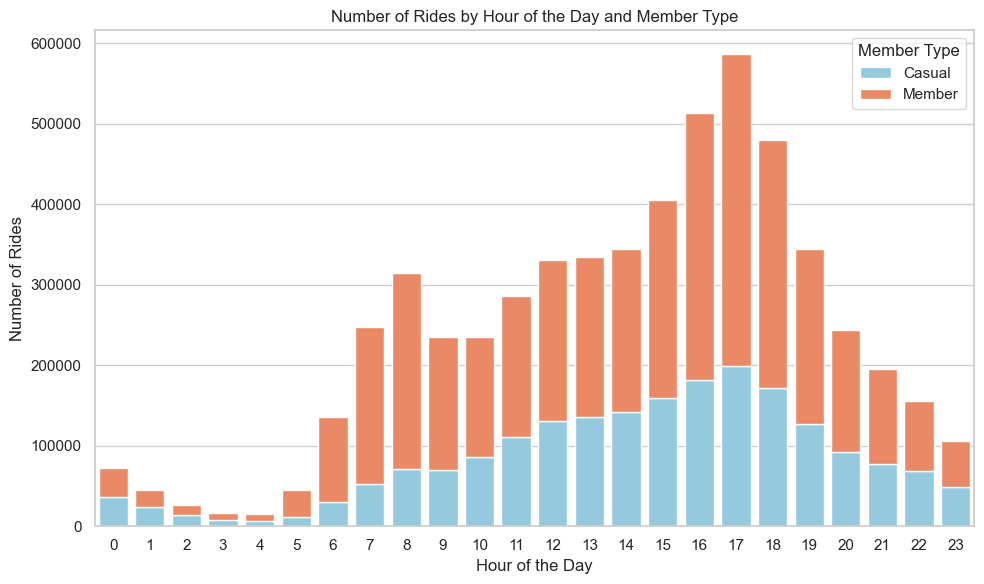

Count of rides by hour and member type:
member_casual  casual  member
hour_of_day                  
0               36724   35519
1               23810   21171
2               14370   12261
3                7887    7927
4                5922    8778
5               11402   34136
6               30096  105294
7               52937  194577
8               70573  244163
9               69824  164855
10              86379  148801
11             110205  176320
12             130444  199880
13             136265  198657
14             142317  201845
15             158808  246670
16             182038  331554
17             198815  387857
18             171687  307683
19             126893  217892
20              91671  151611
21              77098  117733
22              68157   87980
23              49101   56416


In [72]:
# Group by day_of_week and member_casual, count rides
ride_counts_by_hour_member = filled_stations_df.groupby(['hour_of_day', 'member_casual'])['ride_id'].count().unstack()

# Plot the results with Seaborn for clear hue distinction
sns.set_style("whitegrid")  
plt.figure(figsize=(10, 6))
sns.barplot(
    x=ride_counts_by_hour_member.index,
    y=ride_counts_by_hour_member['casual'],  
    color='skyblue',  
    label='Casual'
)
sns.barplot(
    x=ride_counts_by_hour_member.index,
    y=ride_counts_by_hour_member['member'],  
    color='coral',  
    label='Member',
    bottom=ride_counts_by_hour_member['casual']  
)

# Customize the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Hour of the Day and Member Type')
plt.legend(title='Member Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the results
print(f'Count of rides by hour and member type:\n{ride_counts_by_hour_member}')


## Calculate the `ride_counts_by_day_member` and plot it

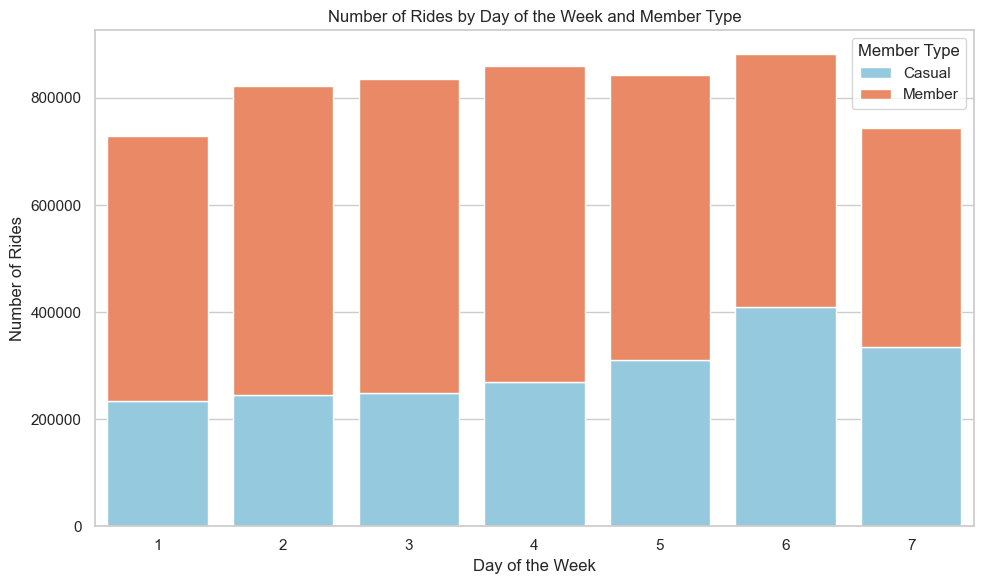

Count of rides by day and member type:
member_casual  casual  member
day_of_week                  
1              234220  494435
2              245619  576588
3              248574  586296
4              269937  589420
5              311095  531432
6              409435  472696
7              334543  408713


In [73]:
# Group by day_of_week and member_casual, count rides
ride_counts_by_day_member = filled_stations_df.groupby(['day_of_week', 'member_casual'])['ride_id'].count().unstack()

# Plot the results with Seaborn for clear hue distinction
sns.set_style("whitegrid")  
plt.figure(figsize=(10, 6))
sns.barplot(
    x=ride_counts_by_day_member.index,
    y=ride_counts_by_day_member['casual'],
    color='skyblue',  
    label='Casual'
)
sns.barplot(
    x=ride_counts_by_day_member.index,
    y=ride_counts_by_day_member['member'],  
    color='coral',  
    label='Member',
    bottom=ride_counts_by_day_member['casual']  
)

# Customize the plot
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Day of the Week and Member Type')
plt.legend(title='Member Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the results
print(f'Count of rides by day and member type:\n{ride_counts_by_day_member}')


## Calculate the `ride_counts_by_month_member` and plot it

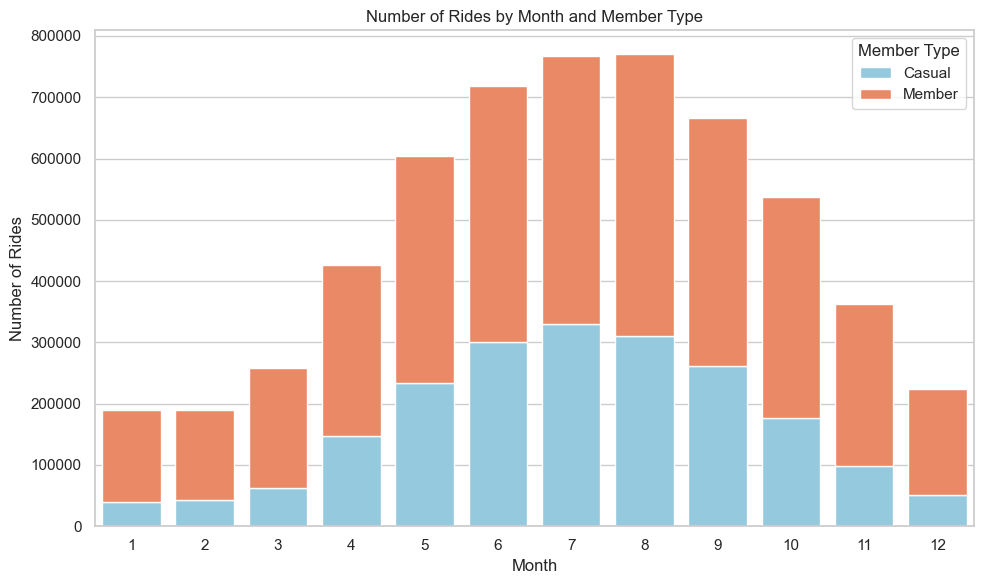

Count of rides by month and member type:
member_casual  casual  member
month                        
1               39905  150269
2               42922  147407
3               62049  196446
4              146894  279261
5              233591  370526
6              300450  418289
7              330313  436148
8              310096  460381
9              260937  404596
10             176620  359907
11              98142  264020
12              51504  172330


In [74]:
# Group by day_of_week and member_casual, count rides
ride_counts_by_month_member = filled_stations_df.groupby(['month', 'member_casual'])['ride_id'].count().unstack()

# Plot the results with Seaborn for clear hue distinction
sns.set_style("whitegrid")  
plt.figure(figsize=(10, 6))
sns.barplot(
    x=ride_counts_by_month_member.index,
    y=ride_counts_by_month_member['casual'],  
    color='skyblue',  
    label='Casual'
)
sns.barplot(
    x=ride_counts_by_month_member.index,
    y=ride_counts_by_month_member['member'],  
    color='coral',  
    label='Member',
    bottom=ride_counts_by_month_member['casual']  
)

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Month and Member Type')
plt.legend(title='Member Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the results
print(f'Count of rides by month and member type:\n{ride_counts_by_month_member}')


## Calculate the `avg_ride_distance_hour` by Member Type

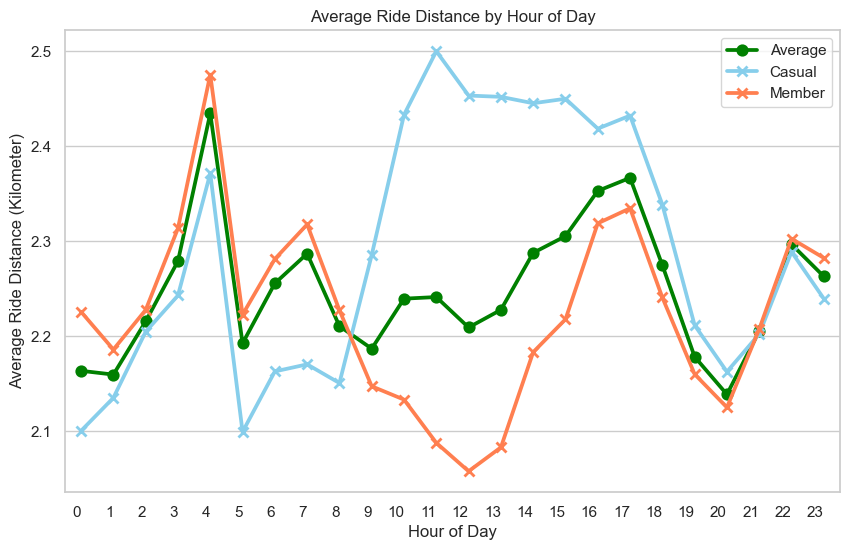

Count of rides by hour of day and member type:
member_casual    casual    member   average
hour_of_day                                
0              2.100396  2.225721  2.163584
1              2.135141  2.185992  2.159615
2              2.204763  2.227732  2.215572
3              2.242960  2.313717  2.279167
4              2.371549  2.475489  2.434687
5              2.099292  2.222762  2.192533
6              2.162948  2.281343  2.255700
7              2.170384  2.317769  2.286996
8              2.150691  2.227404  2.210655
9              2.285631  2.147289  2.186872
10             2.433231  2.133247  2.239569
11             2.500180  2.087713  2.241294
12             2.453517  2.057794  2.209225
13             2.452155  2.082960  2.227814
14             2.445417  2.183224  2.287817
15             2.450150  2.217834  2.305438
16             2.418662  2.318919  2.353053
17             2.432407  2.334789  2.366843
18             2.338610  2.240811  2.274829
19             2.211539  2.16

In [75]:
# Extract hour of the day 
different_station_df['hour_of_day'] = different_station_df['started_at'].dt.hour

# Group by hour of the day and calculate the average route distance
avg_ride_distance_by_hour = different_station_df.groupby(['hour_of_day','member_casual'])['route_distance'].mean().unstack()
avg_ride_distance_by_hour['average'] = different_station_df.groupby('hour_of_day')['route_distance'].mean()


# Set the style for better readability
sns.set(style="whitegrid")

# Plot the results as a point plot with markers using Seaborn
plt.figure(figsize=(10, 6))
sns.pointplot(x=avg_ride_distance_by_hour.index, y=avg_ride_distance_by_hour['average'], data=avg_ride_distance_by_hour, markers='o', linestyles='-', color='green', label='Average')
sns.pointplot(x=avg_ride_distance_by_hour.index, y=avg_ride_distance_by_hour['casual'], data=avg_ride_distance_by_hour, markers='x', linestyles='-', color='skyblue', label='Casual')
sns.pointplot(x=avg_ride_distance_by_hour.index, y=avg_ride_distance_by_hour['member'], data=avg_ride_distance_by_hour, markers='x', linestyles='-', color='coral', label='Member')

# Customize the axes labels and layout
plt.xlabel('Hour of Day')
plt.ylabel('Average Ride Distance (Kilometer)')
plt.title('Average Ride Distance by Hour of Day')


# Show all values on the X-axis
plt.xticks(rotation=0, ha='right')

# Show the plot
plt.show()

# Print the results
print(f'Count of rides by hour of day and member type:\n{avg_ride_distance_by_hour}')

## Calculate the `avg_ride_distance_day` by Member Type

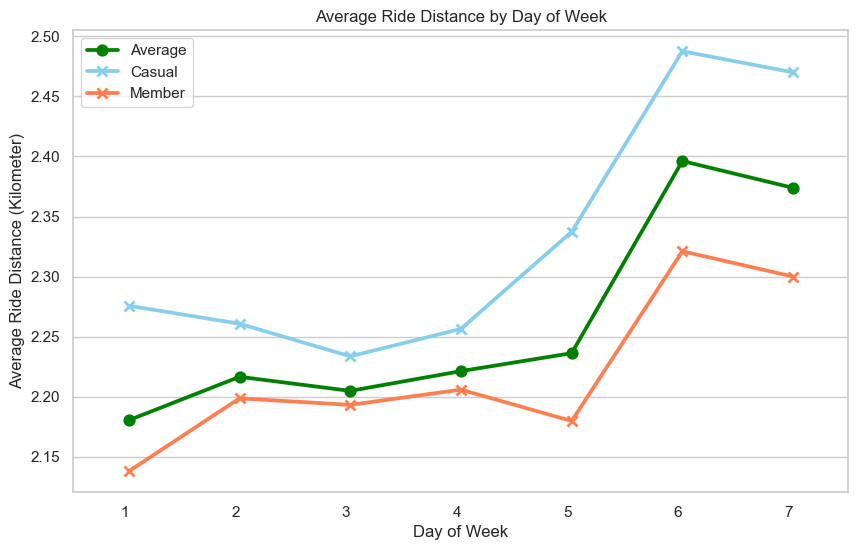

Count of rides by day of the week and member type:
member_casual    casual    member   average
day_of_week                                
1              2.275687  2.137880  2.180376
2              2.260738  2.198605  2.216533
3              2.233575  2.193146  2.204810
4              2.256426  2.205828  2.221258
5              2.337310  2.179730  2.236219
6              2.487636  2.321046  2.396202
7              2.470039  2.299976  2.373885


In [76]:
# Extract day of the week 
different_station_df['day_of_week'] = different_station_df['started_at'].dt.weekday + 1

# Group by day of the week and calculate the average route distance
avg_ride_distance_by_day = different_station_df.groupby(['day_of_week','member_casual'])['route_distance'].mean().unstack()
avg_ride_distance_by_day['average'] = different_station_df.groupby('day_of_week')['route_distance'].mean()


# Set the style for better readability
sns.set(style="whitegrid")

# Plot the results as a point plot with markers using Seaborn
plt.figure(figsize=(10, 6))
sns.pointplot(x=avg_ride_distance_by_day.index, y=avg_ride_distance_by_day['average'], data=avg_ride_distance_by_day, markers='o', linestyles='-', color='green', label='Average')
sns.pointplot(x=avg_ride_distance_by_day.index, y=avg_ride_distance_by_day['casual'], data=avg_ride_distance_by_day, markers='x', linestyles='-', color='skyblue', label='Casual')
sns.pointplot(x=avg_ride_distance_by_day.index, y=avg_ride_distance_by_day['member'], data=avg_ride_distance_by_day, markers='x', linestyles='-', color='coral', label='Member')

# Customize the axes labels and layout
plt.xlabel('Day of Week')
plt.ylabel('Average Ride Distance (Kilometer)')
plt.title('Average Ride Distance by Day of Week')

# Show all values on the X-axis
plt.xticks(rotation=0, ha='right')

# Show the plot
plt.show()

# Print the results
print(f'Count of rides by day of the week and member type:\n{avg_ride_distance_by_day}')

## Calculate the `avg_ride_distance_month` by Member Type

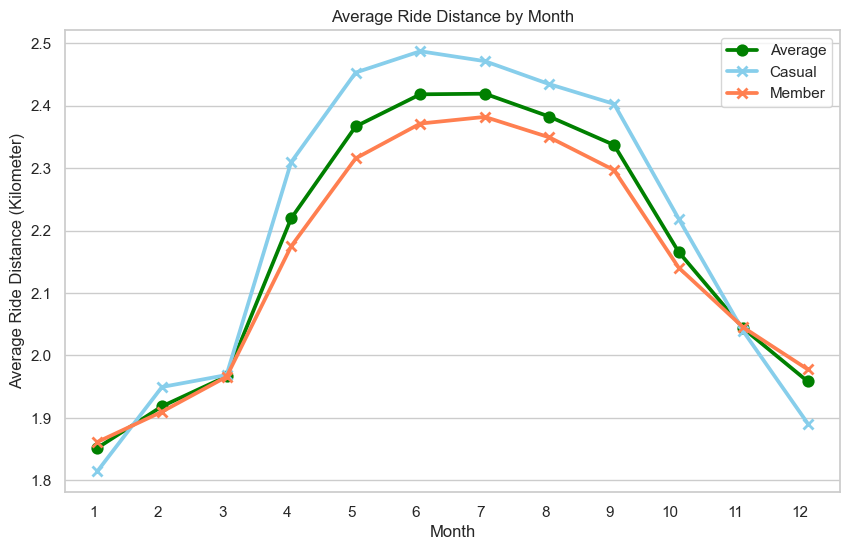

Count of rides by month and member type:
member_casual    casual    member   average
month                                      
1              1.814616  1.861462  1.851913
2              1.949526  1.909903  1.918516
3              1.968656  1.965849  1.966502
4              2.309354  2.174649  2.219336
5              2.452933  2.315554  2.366624
6              2.486974  2.371227  2.418045
7              2.471098  2.381889  2.419016
8              2.434213  2.349071  2.382283
9              2.402689  2.296723  2.336969
10             2.218970  2.140643  2.165710
11             2.038884  2.044989  2.043381
12             1.891006  1.977670  1.958334


In [77]:
# Extract day of the week 
different_station_df['month'] = different_station_df['started_at'].dt.month

# Group by day of the week and calculate the average route distance
avg_ride_distance_by_month = different_station_df.groupby(['month','member_casual'])['route_distance'].mean().unstack()
avg_ride_distance_by_month['average'] = different_station_df.groupby('month')['route_distance'].mean()


# Set the style for better readability
sns.set(style="whitegrid")

# Plot the results as a point plot with markers using Seaborn
plt.figure(figsize=(10, 6))
sns.pointplot(x=avg_ride_distance_by_month.index, y=avg_ride_distance_by_month['average'], data=avg_ride_distance_by_month, markers='o', linestyles='-', color='green', label='Average')
sns.pointplot(x=avg_ride_distance_by_month.index, y=avg_ride_distance_by_month['casual'], data=avg_ride_distance_by_month, markers='x', linestyles='-', color='skyblue', label='Casual')
sns.pointplot(x=avg_ride_distance_by_month.index, y=avg_ride_distance_by_month['member'], data=avg_ride_distance_by_month, markers='x', linestyles='-', color='coral', label='Member')

# Customize the axes labels and layout
plt.xlabel('Month')
plt.ylabel('Average Ride Distance (Kilometer)')
plt.title('Average Ride Distance by Month')

# Show all values on the X-axis
plt.xticks(rotation=0, ha='right')

# Show the plot
plt.show()

# Print the results
print(f'Count of rides by month and member type:\n{avg_ride_distance_by_month}')